In [1]:
import pandas as pd
import numpy as np
import torch
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler


In [2]:
df = pd.read_csv(r'/Users/jamesjirsa/Desktop/Data_Science/JJ_Projects/UFC/new_method/scrape_ufc_stats/final_fight_data.csv')
df

,Unnamed: 0,EVENT,BOUT,OUTCOME,WEIGHTCLASS,METHOD,ROUND,TIME,TIME FORMAT,REFEREE,...,delta_ELO_FIGHTER,delta_AGE,delta_REACH,delta_HEIGHT,delta_SIG_STR_vs_avoid,delta_TD_vs_avoid,PC1,PC2,opponent_PC1,opponent_PC2
0,0,UFC25:UltimateJapan3,TitoOrtizvs.WanderleiSilva,W/L,UFC Light Heavyweight Title Bout,Decision - Unanimous,5,5:00,5 Rnd (5-5-5-5-5),John McCarthy,...,-45.805984,-1.442847,0.0,-4.0,6.735159,0.000000,-2304.093451,111.659258,118.546726,65.301398
1,1,UFC25:UltimateJapan3,TitoOrtizvs.WanderleiSilva,W/L,UFC Light Heavyweight Title Bout,Decision - Unanimous,5,5:00,5 Rnd (5-5-5-5-5),John McCarthy,...,45.805984,1.442847,0.0,4.0,2.471401,-0.099214,118.546726,65.301398,-2304.093451,111.659258
2,4,UFC27:UltimateBadBoyz,JeremyHornvs.EugeneJackson,W/L,Middleweight Bout,Submission,1,4:32,3 Rnd (5-5-5),Mario Yamasaki,...,22.284177,-8.919918,NaN,5.0,-0.250489,0.029975,-849.656402,-362.007419,NaN,NaN
3,5,UFC28:HighStakes,RandyCouturevs.KevinRandleman,W/L,UFC Heavyweight Title Bout,KO/TKO,3,4:13,5 Rnd (5-5-5-5-5),John McCarthy,...,44.264592,8.134155,NaN,3.0,1.838605,0.236066,-1097.109589,-429.197403,NaN,NaN
4,6,UFC28:HighStakes,JensPulvervs.JohnLewis,W/L,Lightweight Bout,KO/TKO,1,0:15,3 Rnd (5-5-5),Mario Yamasaki,...,27.873931,NaN,NaN,-5.0,0.894140,-0.006089,-308.968705,126.665221,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10398,11693,UFCFightNight:Sandhagenvs.Nurmagomedov,ViktoriiaDudakovavs.SamHughes,L/W,Women's Strawweight Bout,Decision - Split,3,5:00,3 Rnd (5-5-5),Daniel Movahedi,...,-53.379668,6.579055,NaN,NaN,-3.026368,0.064299,4453.195258,-934.692022,NaN,NaN
10399,11694,UFCFightNight:Sandhagenvs.Nurmagomedov,SharaMagomedovvs.MichalOleksiejczuk,W/L,Middleweight Bout,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),Daniel Movahedi,...,-24.699481,-0.772074,NaN,-2.0,3.331041,-0.523622,2057.527027,-1488.797293,NaN,NaN
10400,11695,UFCFightNight:Sandhagenvs.Nurmagomedov,TonyFergusonvs.MichaelChiesa,L/W,Welterweight Bout,Submission,1,3:44,3 Rnd (5-5-5),Marc Goddard,...,44.625080,-3.816564,-1.0,2.0,-1.854587,0.117753,8848.342383,-144.344449,13007.510069,-6465.896750
10401,11696,UFCFightNight:Sandhagenvs.Nurmagomedov,MarlonVeravs.DeivesonFigueiredo,L/W,Bantamweight Bout,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),Keith Peterson,...,-57.771347,-4.958248,2.0,3.0,2.894640,-0.048156,15686.349192,-6233.727167,8944.182372,-2843.699104


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10403 entries, 0 to 10402
Columns: 117 entries, Unnamed: 0 to opponent_PC2
dtypes: float64(99), int64(4), object(14)
memory usage: 9.3+ MB


In [4]:
max_fight_idx = df.groupby('FIGHTER')['Fight_Number'].idxmax()
max_fight_rows = df.loc[max_fight_idx]
extra = max_fight_rows[['FIGHTER', 'PC1', 'PC2', 'opponent_PC1', 'opponent_PC1']]
extra = extra.reset_index(drop=True)
extra

,FIGHTER,PC1,PC2,opponent_PC1,opponent_PC1
0,AJDobson,178.871203,-661.693936,2099.588946,2099.588946
1,AJFletcher,-201.858418,-229.327864,-235.930955,-235.930955
2,AaronPhillips,-783.615653,-472.240726,-1620.129449,-1620.129449
3,AaronRiley,2540.248086,-880.391652,-1503.334383,-1503.334383
4,AaronRosa,-926.136453,-406.842729,-1160.301160,-1160.301160
...,...,...,...,...,...
1539,ZhalgasZhumagulov,539.977884,-774.510659,NaN,NaN
1540,ZhangLipeng,349.713406,-113.135222,-1793.255918,-1793.255918
1541,ZhangTiequan,-2463.923013,180.824915,-1523.158013,-1523.158013
1542,ZhangWeili,5507.705001,-1225.935803,5927.162622,5927.162622


In [5]:
pcas =  extra = df[['FIGHTER', 'PC1', 'PC2', 'opponent_PC1', 'opponent_PC1', 'RESULT']]


In [6]:
df = df.drop(['PC1', 'PC2'], axis = 1)

In [7]:
df['RESULT'] = np.where(df['RESULT'] == 'Win', 1,0)

In [8]:
features = df.columns[df.columns.get_loc('ELO_FIGHTER')+1:].tolist()
#features.remove('CUM_index')
features.remove('DOB')
df = df.dropna(subset = 'opponent_PC1')
#df = df.drop(['CUM_index'], axis = 1)

In [9]:
X_train = df[(df['DATE'] >= '2005') & (df['DATE'] < '2024')]
y_train = X_train['RESULT']
X_train = X_train[features]
X_test = df[(df['DATE'] >= '2024')]
y_test = X_test['RESULT']
X_test = X_test[features]
X_train

,CUM_KD,CUM_SIG.STR._Landed,CUM_SIG.STR._Attempted,CUM_SIG.STR._Attempted_avoided,CUM_TOTAL STR._Landed,CUM_TOTAL STR._Attempted,CUM_TOTAL STR._Attempted_avoided,CUM_TD_Landed,CUM_TD_Attempted,CUM_TD_Attempted_avoided,...,delta_CUM_GROUND_Landed_PM,delta_CUM_SUB.ATT_PM,delta_ELO_FIGHTER,delta_AGE,delta_REACH,delta_HEIGHT,delta_SIG_STR_vs_avoid,delta_TD_vs_avoid,opponent_PC1,opponent_PC2
127,4.0,125.0,254.0,52.0,149.0,280.0,52.0,1.0,2.0,7.0,...,-0.595179,0.059553,9.252077,-2.918549,-3.0,-5.0,-1.039820,-0.208319,-1686.440735,-33.892203
128,1.0,85.0,205.0,30.0,181.0,311.0,31.0,3.0,5.0,0.0,...,-0.223441,-0.016748,-29.694413,8.027379,-4.0,1.0,0.040092,0.019479,-404.099894,-128.585700
130,0.0,41.0,108.0,74.0,90.0,165.0,77.0,12.0,21.0,2.0,...,0.223441,0.016748,29.694413,-8.027379,4.0,-1.0,0.425290,0.354331,-245.417718,-477.552826
131,2.0,162.0,278.0,60.0,182.0,299.0,60.0,1.0,1.0,3.0,...,0.595179,-0.059553,-9.252077,2.918549,3.0,5.0,11.308756,-0.129072,-596.172258,-603.930910
132,1.0,399.0,713.0,121.0,1108.0,1457.0,135.0,38.0,58.0,8.0,...,0.780805,-0.085291,40.492379,2.187543,0.0,3.0,2.198596,0.222327,172.349450,-874.033760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10021,1.0,179.0,303.0,25.0,288.0,421.0,28.0,4.0,12.0,3.0,...,0.468798,0.099379,11.580876,-11.696099,2.0,1.0,2.335976,0.067498,13947.713613,-6190.022887
10022,10.0,1186.0,2587.0,596.0,1398.0,2825.0,662.0,5.0,12.0,9.0,...,-0.468798,-0.099379,-11.580876,11.696099,-2.0,-1.0,3.580086,-0.056823,212.659292,133.762182
10023,11.0,729.0,2002.0,785.0,789.0,2086.0,794.0,11.0,29.0,5.0,...,-0.647416,-0.101734,-8.354983,9.585216,0.0,-4.0,2.519132,0.032150,4499.653023,449.632336
10024,1.0,130.0,281.0,77.0,179.0,336.0,81.0,2.0,8.0,9.0,...,-0.090649,0.097999,10.047904,-10.891170,-3.0,-1.0,0.479150,-0.034376,12162.340109,-6077.626607


In [ ]:
X = StandardScaler().fit_transform(X_train)

# Add a column of ones for the intercept
X = np.hstack([np.ones((X.shape[0], 1)), X])
y = y_train

In [ ]:
with pm.Model() as logistic_model:
    intercept = pm.Normal('intercept', mu=0, sigma=10)
    coefs = pm.Normal('coefs', mu=0, sigma=10, shape=X.shape[1] - 1)
    logit_p = intercept + pm.math.dot(X[:, 1:], coefs)
    likelihood = pm.Bernoulli('y_train', logit_p=logit_p, observed=y_train)
    trace = pm.sample(2000, tune=1000,target_accept=0.91, chains = 4, cores=-1, return_inferencedata=True, progressbar = True)


In [ ]:
az.summary(trace)
az.plot_trace(trace)
plt.show()
az.plot_posterior(trace)
plt.show()


In [ ]:
with logistic_model:
    pm.set_data({"X_test": X_test})  # Replace X_new with new data
    posterior_predictive = pm.sample_posterior_predictive(trace)

# The predicted labels are in `posterior_predictive['y']`
predictions = np.mean(posterior_predictive['y'], axis=0)


In [ ]:
import pymc as pm
import numpy as np
import aesara.tensor as at

# Define the neural network structure
def neural_network(X):
    n_hidden = 5  # Number of hidden units

    # Priors for weights and biases
    w_0 = pm.Normal('w_0', mu=0, sigma=1, shape=(X.shape[1], n_hidden))
    b_0 = pm.Normal('b_0', mu=0, sigma=1, shape=(n_hidden,))

    w_1 = pm.Normal('w_1', mu=0, sigma=1, shape=(n_hidden,))
    b_1 = pm.Normal('b_1', mu=0, sigma=1)

    # Hidden layer
    h = at.tanh(at.dot(X, w_0) + b_0)

    # Output layer (logit)
    output = at.dot(h, w_1) + b_1
    return output

# Prepare data (ensure X is a NumPy array and y is the target)
X = np.array(X_train)
y = np.array(y_train)

with pm.Model() as model:
    # Define the non-linear model
    logit_p = neural_network(X)
    
    # Likelihood
    likelihood = pm.Bernoulli('y', logit_p=logit_p, observed=y)
    
    # Sample from the posterior
    trace = pm.sample(2000, tune=1000, chains=4, cores=2, target_accept=0.95)
    
    # Plot the trace
    az.plot_trace(trace)
    plt.show()


In [28]:
pcas = pcas.dropna(subset = 'opponent_PC1')
pcas = pcas.dropna(subset = 'PC1')
pcas['RESULT'] = np.where(pcas['RESULT'] == 'Win', 1,0)
X = pcas.iloc[:, 1:5].values
y = pcas['RESULT'].values


In [29]:
with pm.Model() as gp_model:
    # Define the GP covariance function (kernel)
    cov_func = pm.gp.cov.ExpQuad(4, ls=1.0)

    # Define the GP
    gp = pm.gp.Latent(cov_func=cov_func)
    
    # Latent GP prior
    f = gp.prior("f", X=X)
    
    # Logistic likelihood
    likelihood = pm.Bernoulli("y", logit_p=f, observed=y)
    
    # Sample from the posterior
    trace = pm.sample(2000, tune=1000, chains=2, cores=4, target_accept=0.90, return_inferencedata=True, progressbar = True,
                      nuts_sampler = 'numpyro')

# Plotting the trace and credible intervals would be similar as before.


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

We recommend running at least 4 chains for robust computation of convergence diagnostics


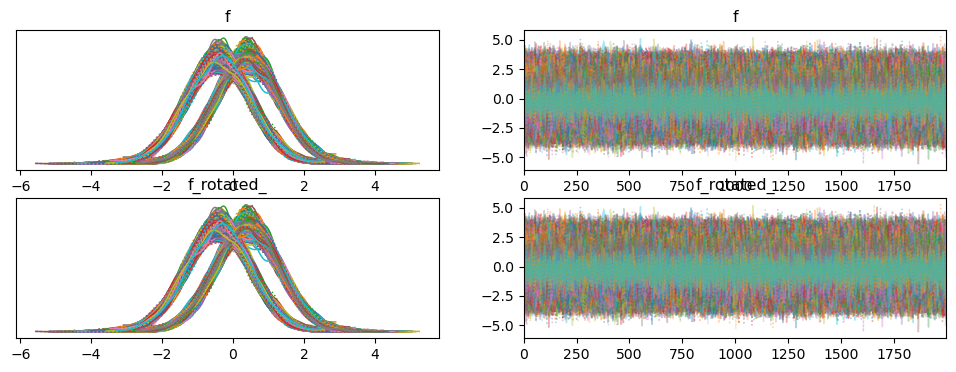

In [32]:
az.plot_trace(trace)
plt.show()

In [41]:
from datetime import datetime
X_new = np.random.randn(10, 4)  # Replace with actual new data points

with gp_model:
    # Use a unique name based on the current date and time
    pred_name = f"f_pred_{datetime.now().strftime('%Y%m%d_%H%M%S')}"

    # Condition the GP on the new input data
    f_pred_new = gp.conditional(pred_name, Xnew=X_new)
    
    # Manually sample from the GP conditional
    pred_samples = pm.sample_posterior_predictive(trace, var_names=[pred_name])

# Check what keys exist in the predictive samples
print("Available keys in pred_samples:", pred_samples.keys())

# Extract the mean and credible intervals for the new predictions
if pred_name in pred_samples:
    pred_mean = np.mean(pred_samples[pred_name], axis=0)
    pred_credible_interval = np.percentile(pred_samples[pred_name], [2.5, 97.5], axis=0)
    
    print("Predicted Mean:", pred_mean)
    print("95% Credible Interval:", pred_credible_interval)
else:
    print(f"Key '{pred_name}' not found in posterior predictive samples.")


Sampling: [f_pred_20240904_115536]


Output()

Available keys in pred_samples: KeysView(Inference data with groups:
	> posterior_predictive
	> observed_data)
Key 'f_pred_20240904_115536' not found in posterior predictive samples.


In [43]:
gp_model

            f_rotated_ ~ Normal(0, 1)
                f_pred ~ MultivariateNormal(f(f_rotated_), f())
                f_pred ~ MultivariateNormal(f(f_rotated_), f())
                f_pred ~ MultivariateNormal(f(f_rotated_), f())
f_pred_20240904_114905 ~ MultivariateNormal(f(f_rotated_), f())
f_pred_20240904_114927 ~ MultivariateNormal(f(f_rotated_), f())
f_pred_20240904_115008 ~ MultivariateNormal(f(f_rotated_), f())
f_pred_20240904_115114 ~ MultivariateNormal(f(f_rotated_), f())
f_pred_20240904_115429 ~ MultivariateNormal(f(f_rotated_), f())
f_pred_20240904_115536 ~ MultivariateNormal(f(f_rotated_), f())
                     f ~ Deterministic(f(f_rotated_))
                     y ~ Bernoulli(f(f_rotated_))